In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Klasyfikacja

Klasyfikacja zalicza się do metod uczenia nadzorowanego (ang. supervised learning). Zbiór (macierz) danych w tym przypadku składa się z obiektów charakteryzujących się atrybutami opisującymi i atrybutem decyzyjnym. Przyjmuje się przy tym, że pomiędzy atrybutami opisującymi, a atrybutem decyzyjnym zachodzi pewien związek przyczynowo-skutkowy zaś kategoryczny atrybut decyzyjny określa klasę do której przynależy obiekt. Zbiór danych jest traktowany jako źródło wiedzy na podstawie którego określa się rodzaj klasyfikatora, a następnie dobiera jego parametry w tzw. procesie uczenia. Gotowy klasyfikator może następnie zostać wykorzystany do określenia przynależności obiektu dla którego znane są jedynie wartości atrybutów opisujących do właściwej klasy. 

Z reguły w celu sprawdzenia poprawności danego algorytmu i sprawdzenia jego skuteczności dla danego zadania klasyfikacji podział zbioru danych wykonywany jest na zbiór uczący i testowy (najczęściej w proporcjach 80/20 lub 70/30). Czasem jednak w przypadku testowania algorytmów i ich dostrajania stosuje się podział 60/20/20, a poszczególne części stanową zbiory odpowiednio: treningowy, walidacyjny i testowy. 

W rozdziale tym skupimy się na następujących klasyfikacji SVM


Na końcu zaprezentowane zostaną metody łączenia wyników różnych klasyfikatorów (tzw. ensemblingu), w celu poprawy jakości klasyfikacji.


Wygenerujemy teraz nowy zbiór z klastrami bardziej się nakładającymi

In [2]:
from sklearn.datasets import make_blobs
def gen_sets(cluster_std=1):
    X3, y3 = make_blobs(n_samples=500,
                      n_features=2,
                      centers=2,
                      cluster_std=cluster_std,
                      center_box=(-10.0, 10.0),
                      shuffle=True,    # przetasowanie kolejności próbek
                      random_state=1)  # ustawienie momentu startu zmiennej pseudolosowej w celu zapewnienia powtarzalności wyników
    columns = ['feature' + str(x) for x in np.arange(1, X3.shape[1]+1, 1)]
    d = {key: values for key, values in zip(columns, X3.T)}
    d['label'] = y3
    dane3 = pd.DataFrame(d).reindex(columns=columns+['label'])

    #Wyświelenie blobów
    plt.figure(figsize=(8,8))
    plt.scatter(dane3.feature1, dane3.feature2, marker='o', c=dane3.label)


    return dane3

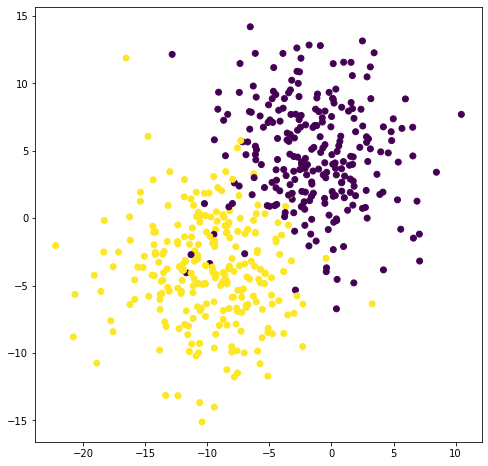

In [3]:
dane3 = gen_sets(4)

### 2.4 SVM
Metoda wektorów nośnych/SVM z ang. Support Vector Machine jest algorytmem, którego zadaniem jest podzielenie przestrzeni cech przy pomocy wektorów nośnych. W przypadku 2 cech, które można zobrazować na wykresie płaskim, jest są to po proste (w przypadku jądra liniowego) lub wielomiany lub funkcja Gaussa (w przypadku jąder nieliniowych). Jądra liniowe są szybkie i proste w użyciu, jednakże nadają się do klasyfikacji obszarów wyraźnie od siebie odstających. W celu dokładnego wyodrębnienia obszarów należy użyć jąder nieliniowych, uważając na przeuczenie klasyfikatora.   

/home/mccastles/.cache/pypoetry/virtualenvs/workspace-py3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


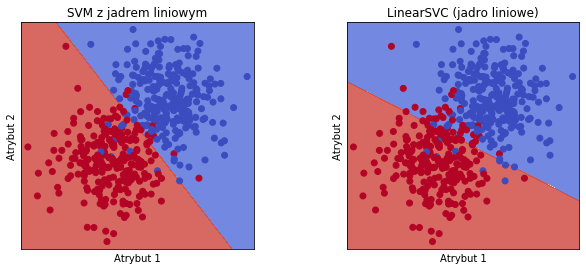

In [4]:
from sklearn import svm
h = .02  # step size in the mesh

cechy = list(dane3.columns[:2])

C = 1000.0  # SVM regularization parameter


lin_svc = svm.LinearSVC(C=C).fit(dane3[cechy], dane3['label'])
svc = svm.SVC(kernel='linear', C=C).fit(dane3[cechy], dane3['label'])


x_min, x_max = dane3.iloc[:, 0].min() - 1, dane3.iloc[:, 0].max() + 1
y_min, y_max = dane3.iloc[:, 1].min() - 1, dane3.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVM z jadrem liniowym', 'LinearSVC (jadro liniowe)']

plt.figure(figsize=(10,10))
# for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
for i, clf in enumerate((svc, lin_svc)):    
    
    
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(dane3.iloc[:, 0], dane3.iloc[:, 1], c=dane3.label, cmap=plt.cm.coolwarm)
    plt.xlabel('Atrybut 1')
    plt.ylabel('Atrybut 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

#### Zadanie 2.5
Następnie przy pomocy zbioru treningowym X3 należy nauczyć model dla parametru wybranego w poprzednim zadaniu. Po nauczeniu należy dokonać predykcji wyników dla zbioru testowego X3. Następnie wyświetlony zostanie raport klasyfikacji. W raporcie tym otrzymujemy 3 podstawowe miary: prezycję (ang. precision), czułość (ang. recall) i miarę $f_1 = 2*\frac{precyzja * czułość}{precyzja+czułość}$. 

* Precyzja jest miarą wskazującą z jaką pewnością możemy ufać przewidywaniom pozytywnym: $precyzja = \frac{TP}{TP+FP}$  


* Czułość jest miarą wskazującą w jakim procencie klasa faktycznie pozytywna została pokryta przewidywaniem pozytywnym: $czułość = \frac{TP}{TP+FN}$ 

Dodatkowo wyświetlimy macierz pewności prezentującą, do której klasy zostały zaklasyfikowane obserwacje danych klas.

## Generacja parametru C

In [5]:
cv = 5
start = 10
step = 10
no_C = 10
C_range = range(start, step * no_C + 2, step)

## Dane X i y, wyskalowane

In [6]:
X = dane3[cechy]
y = dane3['label']

In [7]:
scaler = StandardScaler()
sX = scaler.fit_transform(np.array(X).reshape(-1,2))

## Podział dane3 na train i test oraz skalowanie

In [8]:
X3_train, X3_test, y3_train, y3_test = train_test_split(dane3[cechy], dane3['label'], test_size=0.2, random_state=1)
print ('Dlugosc X3_train: ', len(X3_train))
print ('Dlugosc X3_test: ', len(X3_test))
print ('Dlugosc y3_train: ', len(y3_train))
print ('Dlugosc y3_test: ', len(y3_test))

Dlugosc X3_train:  400
Dlugosc X3_test:  100
Dlugosc y3_train:  400
Dlugosc y3_test:  100


In [9]:
sX3_train = scaler.fit_transform(np.array(X3_train).reshape(-1,2))
sX3_test = scaler.fit_transform(np.array(X3_test).reshape(-1,2))

Text(0.5, 1.0, 'scaled test')

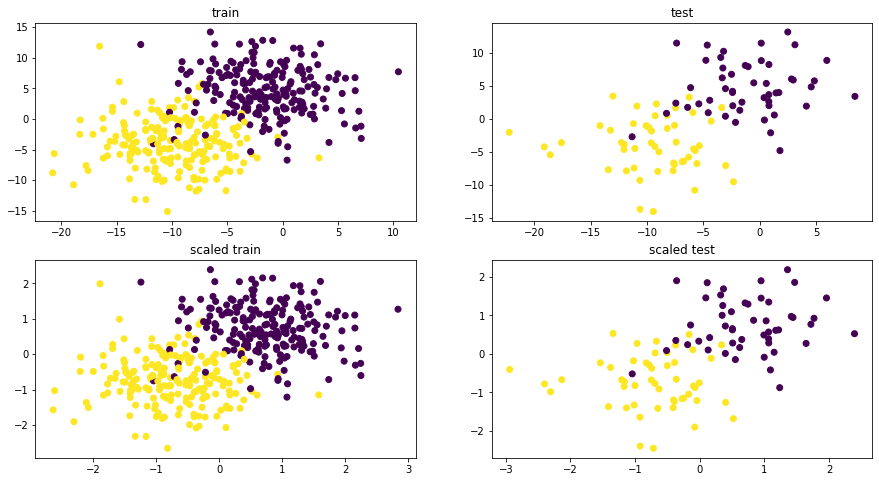

In [10]:
plt.figure(figsize=(15,8))

plt.subplot(2, 2, 1)
plt.scatter(X3_train['feature1'], X3_train['feature2'], marker='o', c=y3_train)
plt.title('train')

plt.subplot(2, 2, 2)
plt.scatter(X3_test['feature1'], X3_test['feature2'], marker='o', c=y3_test)
plt.title('test')

plt.subplot(2, 2, 3)
plt.scatter(sX3_train[:,0], sX3_train[:,1], marker='o', c=y3_train)
plt.title('scaled train')

plt.subplot(2, 2, 4)
plt.scatter(sX3_test[:,0], sX3_test[:,1], marker='o', c=y3_test)
plt.title('scaled test')

## Funkcje dla znalezienia najlepszego C

In [11]:
def linsvc_CV():
    scores = {}
    for C in C_range:
        
        svc = svm.SVC(kernel='linear', C=C)
        lin = svm.LinearSVC(C=C, max_iter=50000)
        
        svc.fit(sX, y)
        lin.fit(sX, y)
        
        score_svc = cross_val_score(svc, sX, y, cv=cv, scoring="accuracy")
        score_lin = cross_val_score(lin, sX, y, cv=cv, scoring="accuracy")
        

        print("Accuracy SVC: %0.2f (+/- %0.2f)" % (score_svc.mean(), score_svc.std() * 2))
        print("Accuracy Linear: %0.2f (+/- %0.2f)" % (score_lin.mean(), score_lin.std() * 2))
        
        scores[C] = (score_lin.mean(), score_svc.mean())
    return scores

In [12]:
def draw_C(scores):
    plt.figure(figsize=(20, 5), dpi=80)

    x_plt = np.linspace(min(scores.keys()), max(scores.keys()), 100)
    plt.plot(C_range, [i[0] for i in scores.values()], color='red', label='Lin')
    plt.plot(C_range, [i[1] for i in scores.values()], color='blue', label='Svc')
    plt.legend()
    plt.show()

## Pipeline dla liniowych

In [13]:
def find_best_C(CV_func):
    scores = CV_func()
    draw_C(scores)
    best_C = max(scores, key=scores.get)
    print('Best C is', best_C)
    return best_C

In [14]:
def full_report(lin, svc):

    lin.fit(sX3_train, y3_train)
    svc.fit(sX3_train, y3_train)


    lin_pred = lin.predict(sX3_test)
    svc_pred = svc.predict(sX3_test)
    ns_pred = [0 for _ in range(len(y3_test))]


    ns_auc = roc_auc_score(y3_test, ns_pred)
    lin_auc = roc_auc_score(y3_test, lin_pred)
    svc_auc = roc_auc_score(y3_test, svc_pred)


    print('Classification Report: Linear')
    print(classification_report(y3_test, lin_pred))
    print('\n\n')

    print('Classification Report: SVC')
    print(classification_report(y3_test, svc_pred))
    print('\n\n')



    plt.figure(figsize = (15,5))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y3_test, lin_pred), annot=True)
    plt.title('Confusion Matrix: Linear')

    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y3_test, svc_pred), annot=True)
    plt.title('Confusion Matrix: SVC')
    plt.show()

    print('\n\n')


    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Linear: ROC AUC=%.3f' % (lin_auc))
    print('SVC: ROC AUC=%.3f' % (svc_auc))


    ns_fpr, ns_tpr, _ = roc_curve(y3_test, ns_pred)
    lin_fpr, lin_tpr, _ = roc_curve(y3_test, lin_pred)
    svc_fpr, svc_tpr, _ = roc_curve(y3_test, svc_pred)

    plt.figure(figsize = (10,7))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lin_fpr, lin_tpr, marker='.', label='Linear')
    plt.plot(svc_fpr, svc_tpr, marker='.', label='SVC')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

## Raport dla liniowych

Accuracy SVC: 0.95 (+/- 0.04)
Accuracy Linear: 0.95 (+/- 0.03)
Accuracy SVC: 0.95 (+/- 0.04)
Accuracy Linear: 0.95 (+/- 0.03)
Accuracy SVC: 0.95 (+/- 0.04)
Accuracy Linear: 0.95 (+/- 0.03)
Accuracy SVC: 0.95 (+/- 0.04)
Accuracy Linear: 0.95 (+/- 0.03)
Accuracy SVC: 0.95 (+/- 0.04)
Accuracy Linear: 0.95 (+/- 0.03)
Accuracy SVC: 0.95 (+/- 0.04)
Accuracy Linear: 0.95 (+/- 0.03)
Accuracy SVC: 0.95 (+/- 0.04)
Accuracy Linear: 0.95 (+/- 0.03)
Accuracy SVC: 0.95 (+/- 0.04)
Accuracy Linear: 0.95 (+/- 0.03)
Accuracy SVC: 0.95 (+/- 0.04)
Accuracy Linear: 0.95 (+/- 0.03)
Accuracy SVC: 0.95 (+/- 0.04)
Accuracy Linear: 0.95 (+/- 0.03)


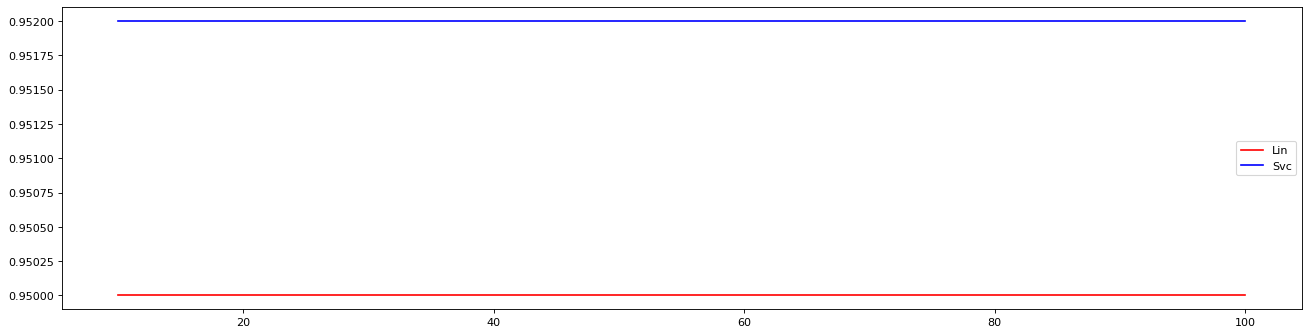

Best C is 10
Classification Report: Linear
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        50
           1       0.94      0.94      0.94        50

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100




Classification Report: SVC
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        50
           1       0.92      0.94      0.93        50

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100






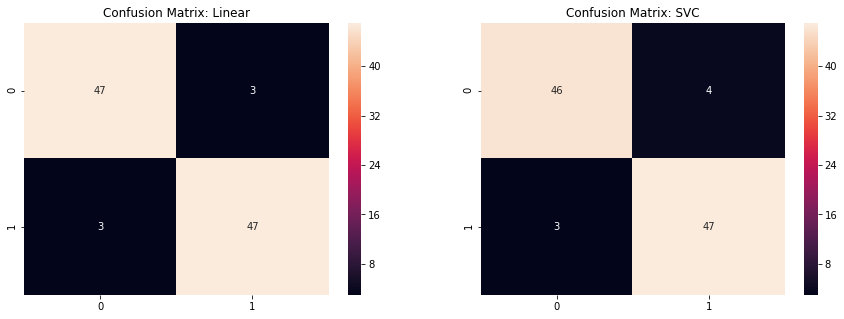




No Skill: ROC AUC=0.500
Linear: ROC AUC=0.940
SVC: ROC AUC=0.930


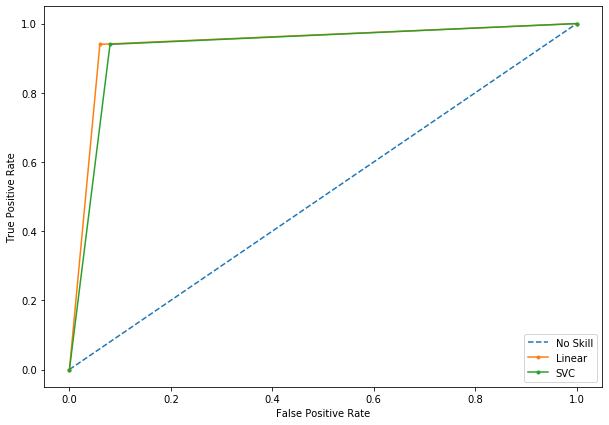

In [15]:
best_lin_C = find_best_C(linsvc_CV)
full_report(
    svm.LinearSVC(C=best_lin_C, max_iter=10000),
    svm.SVC(kernel='linear', C=best_lin_C)
)

In [18]:
def polyrbf_CV():
    scores = {}
    for C in C_range:
        
        poly_svc = svm.SVC(kernel='poly', degree=3, gamma='auto', C=C).fit(sX, y)
        rbf_svc = svm.SVC(kernel='rbf', gamma='auto', C=C).fit(sX, y)

        score_poly_svc = cross_val_score(poly_svc, sX, y, cv=cv, scoring="accuracy")
        score_rbf_svc = cross_val_score(rbf_svc, sX, y, cv=cv, scoring="accuracy")

        

        print("Accuracy Poly: %0.2f (+/- %0.2f)" % (score_poly_svc.mean(), score_poly_svc.std() * 2))
        print("Accuracy RBF: %0.2f (+/- %0.2f)" % (score_rbf_svc.mean(), score_rbf_svc.std() * 2))
        
        scores[C] = (score_rbf_svc.mean(), score_poly_svc.mean())
    return scores

## Raport dla Poly i RBF

Accuracy Poly: 0.94 (+/- 0.04)
Accuracy RBF: 0.94 (+/- 0.04)
Accuracy Poly: 0.94 (+/- 0.03)
Accuracy RBF: 0.94 (+/- 0.05)
Accuracy Poly: 0.95 (+/- 0.04)
Accuracy RBF: 0.94 (+/- 0.05)
Accuracy Poly: 0.94 (+/- 0.03)
Accuracy RBF: 0.94 (+/- 0.05)
Accuracy Poly: 0.94 (+/- 0.03)
Accuracy RBF: 0.94 (+/- 0.05)
Accuracy Poly: 0.95 (+/- 0.04)
Accuracy RBF: 0.94 (+/- 0.05)
Accuracy Poly: 0.95 (+/- 0.04)
Accuracy RBF: 0.94 (+/- 0.05)
Accuracy Poly: 0.94 (+/- 0.03)
Accuracy RBF: 0.94 (+/- 0.04)
Accuracy Poly: 0.94 (+/- 0.03)
Accuracy RBF: 0.94 (+/- 0.04)
Accuracy Poly: 0.94 (+/- 0.03)
Accuracy RBF: 0.94 (+/- 0.04)


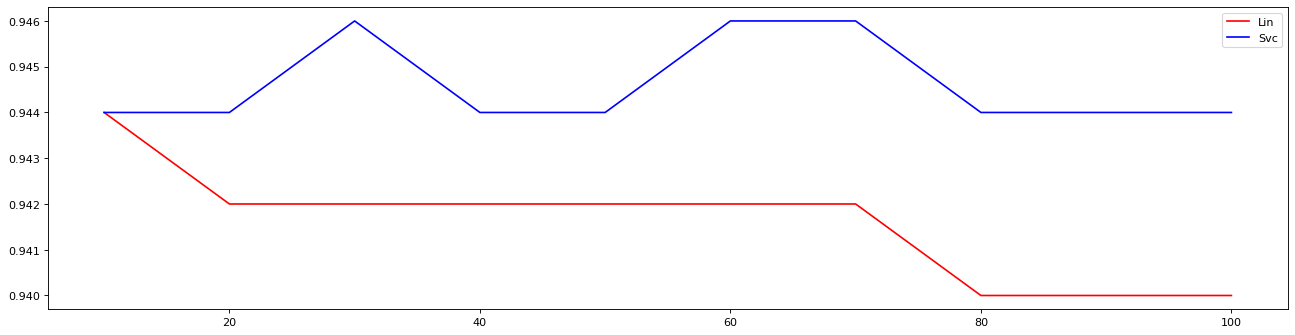

Best C is 10
Classification Report: Linear
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        50
           1       0.91      0.96      0.93        50

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100




Classification Report: SVC
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        50
           1       0.92      0.96      0.94        50

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100






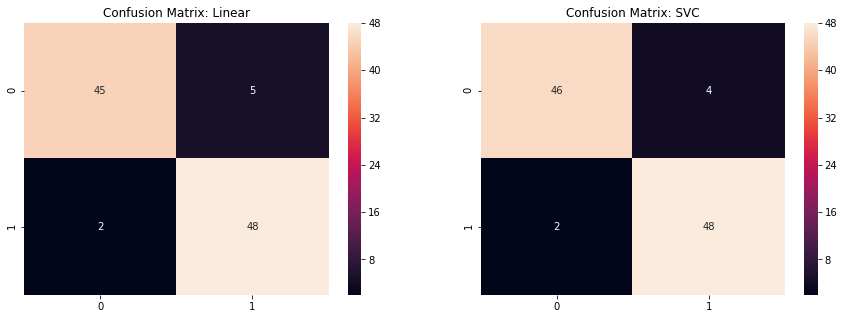




No Skill: ROC AUC=0.500
Linear: ROC AUC=0.930
SVC: ROC AUC=0.940


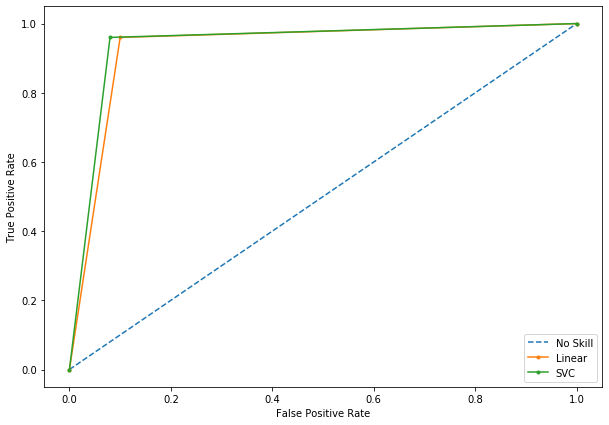

In [19]:
best_poly_C = find_best_C(polyrbf_CV)
full_report(
    svm.SVC(kernel='poly', degree=3, gamma='auto', C=best_poly_C).fit(sX, y),
    svm.SVC(kernel='rbf', gamma='auto', C=C).fit(sX, y)
)